# Credit Card Default Propensity Prediction

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import kaggle
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Loading Datasets from Kaggle via API

In [2]:
# You will need a Kaggle API to run this command. You can find documentation at https://www.kaggle.com/docs/api
!kaggle datasets download -d subhamjain/loan-prediction-based-on-customer-behavior

Dataset URL: https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior
License(s): other
loan-prediction-based-on-customer-behavior.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zip_path = 'loan-prediction-based-on-customer-behavior.zip'

def load_csv_files(zip_path):
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Get a list of all CSV files in the archive
        csv_files = [f for f in z.namelist() if f.endswith('.csv')]
        
        if not csv_files:
            raise ValueError("No CSV files found in {}".format(zip_path))
        
        # Iterate over each CSV file and load it into a DataFrame
        for file in csv_files:
            df = pd.read_csv(z.open(file))
            dataframes[file] = df  # Store the DataFrame with its file name as key
            
    return dataframes

# Load all CSV files into a dictionary of DataFrames
dfs_dictionary = load_csv_files(zip_path)

# Print the names of the CSV files and show the first few rows of each DataFrame.
for filename, df in dfs_dictionary.items():
    print(f"File: {filename}:")
    print(f"Shape: {df.shape}")
    display(df.head(3))

File: Sample Prediction Dataset.csv:
Shape: (28000, 2)


,id,risk_flag
0,1,0
1,2,0
2,3,1


File: Test Data.csv:
Shape: (28000, 12)


,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14


File: Training Data.csv:
Shape: (252000, 13)


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0


## Concatenating the three datasets into just one big dataset

In [4]:
# Store datasets into pandas dfs
df_test_x = dfs_dictionary["Test Data.csv"]
df_test_y = dfs_dictionary["Sample Prediction Dataset.csv"]
df_training = dfs_dictionary["Training Data.csv"]

# Concatenate everything into just one big dataset
df_test = pd.merge(df_test_x, df_test_y, how = "left", left_on = "ID", right_on = "id")

# Cleaning both datasets and show first rows
df_test = df_test.drop("id", axis=1)
df_test = df_test.drop("ID", axis=1)

df_training = df_training.drop("Id", axis=1)
df_training = df_training.rename(columns = {'Risk_Flag': 'risk_flag'})

display(df_test.head(1))
display(df_training.head(1))

# Checking if correctly cleaned and merging
if sorted(set(df_test.columns)) == sorted(set(df_training.columns)):
    df_complete = pd.concat([df_test, df_training])
else:
    raise ValueError("Columns are not the same.")

if len(df_complete) == len(df_test) + len(df_training):
    print("Correctly concatenated!")
df_complete.head(1)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,risk_flag
0,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,0


,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,risk_flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0


Correctly concatenated!


,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,risk_flag
0,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,0


## Exploratory Data Analysis

Some overall highlights:
- There are no missing values.
- We have numerical and categorical columns.
- There are some key variables with a high correlation with the target variable. Also, some categorical variables seem to be relevant to increase the average value of the target variable, so they will be included as dummy variables. 
- _Note: We had to drop some categorical variables (city, state, and profession) for having too many cateogories. With more time and resources, we could group some of them together to reduce the number of categories instead of dropping the complete datapoint._

Numerical variables:
- The distribution of the numerical variables does not show skewness.
- The dataset is very imbalanced in terms of the target variable (risk_flag).
- We will need to scale the features

Categorical variables:
- Some of the columns have too many categories for basic models to handle. We will drop them due to the lack of time to reduce the number of categories by grouping them together.

Target Variable:
- Very imbalanced

Check the following cells to see the analysis conducted to reach the previous conclusions.

### Initial information

In [5]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             280000 non-null  int64 
 1   Age                280000 non-null  int64 
 2   Experience         280000 non-null  int64 
 3   Married/Single     280000 non-null  object
 4   House_Ownership    280000 non-null  object
 5   Car_Ownership      280000 non-null  object
 6   Profession         280000 non-null  object
 7   CITY               280000 non-null  object
 8   STATE              280000 non-null  object
 9   CURRENT_JOB_YRS    280000 non-null  int64 
 10  CURRENT_HOUSE_YRS  280000 non-null  int64 
 11  risk_flag          280000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 27.8+ MB


In [6]:
# List of categorical columns (object or category types)
lst_categorical_vars = list(df_complete.select_dtypes(include=['object', 'category']).columns)

# List of numerical columns
lst_numerical_vars = list(df_complete.select_dtypes(include=['number']).columns)

print("Categorical variables:", lst_categorical_vars)
print("Numerical variables:", lst_numerical_vars)

Categorical variables: ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
Numerical variables: ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'risk_flag']


### Analysis of the categorical variables

Exploratory Data Analysis for 'Married/Single':
--------------------------------------------------
Unique Categories: 2
Missing Values: 0 (0.00%)
Value Counts:
single     251442
married     28558
Name: Married/Single, dtype: int64




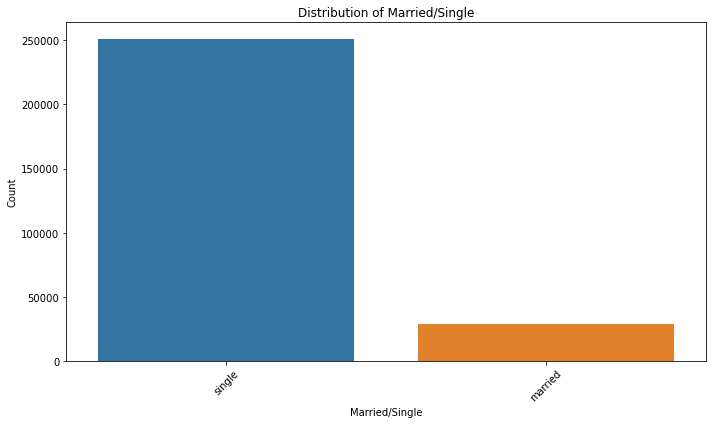

Exploratory Data Analysis for 'House_Ownership':
--------------------------------------------------
Unique Categories: 3
Missing Values: 0 (0.00%)
Value Counts:
rented          257703
owned            14348
norent_noown      7949
Name: House_Ownership, dtype: int64




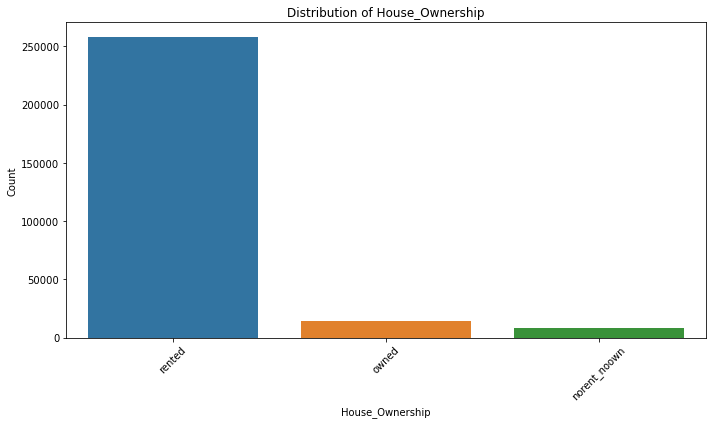

Exploratory Data Analysis for 'Car_Ownership':
--------------------------------------------------
Unique Categories: 2
Missing Values: 0 (0.00%)
Value Counts:
no     195625
yes     84375
Name: Car_Ownership, dtype: int64




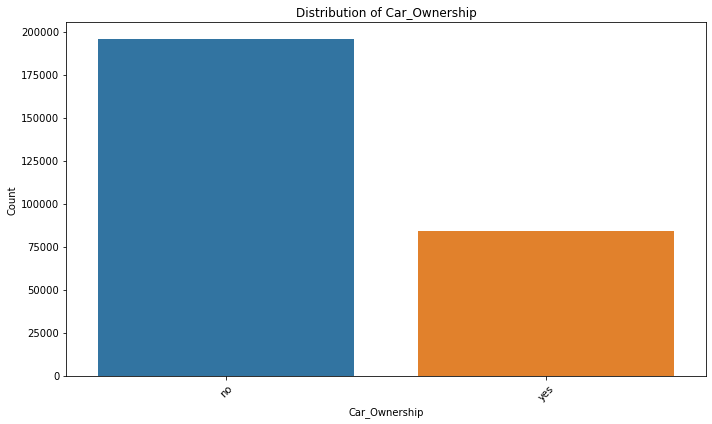

Exploratory Data Analysis for 'Profession':
--------------------------------------------------
Unique Categories: 74
Missing Values: 0 (0.00%)
Value Counts:
Physician          6587
Statistician       6478
Psychologist       6004
Magistrate         5932
Drafter            5932
                   ... 
Police officer      516
Design Engineer     509
Army officer        501
Civil servant       490
Civil engineer      461
Name: Profession, Length: 74, dtype: int64




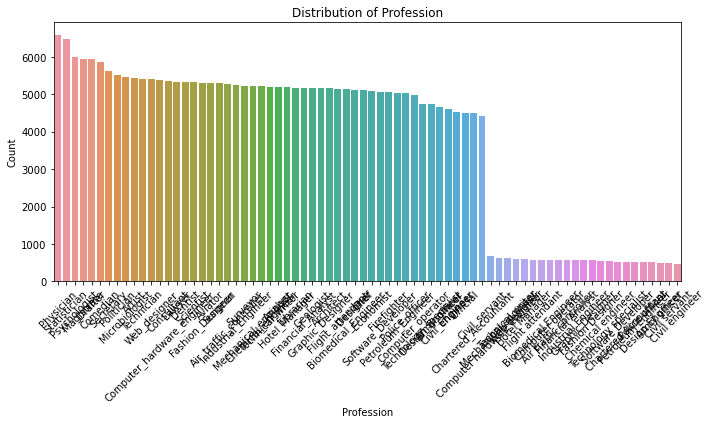

Exploratory Data Analysis for 'CITY':
--------------------------------------------------
Unique Categories: 333
Missing Values: 0 (0.00%)
Value Counts:
Vijayanagaram            1407
Bhopal                   1336
Saharsa[29]              1333
Bulandshahr              1329
Vijayawada               1294
                         ... 
Surendranagar Dudhrej      72
Bihar Sharif               70
Nangloi Jat                67
Sri Ganganagar             63
Sultan Pur Majra           61
Name: CITY, Length: 333, dtype: int64




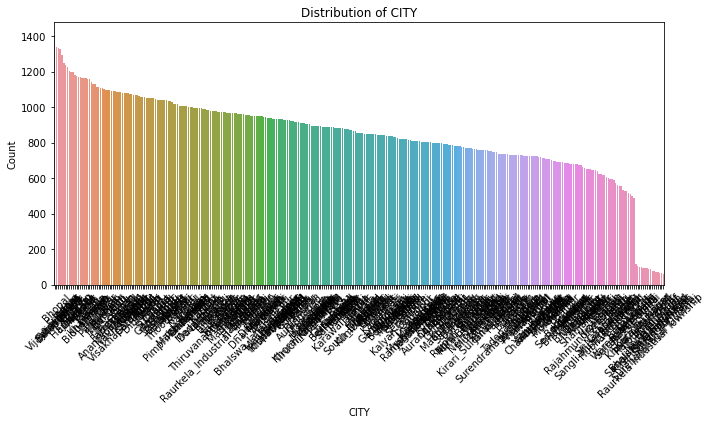

Exploratory Data Analysis for 'STATE':
--------------------------------------------------
Unique Categories: 37
Missing Values: 0 (0.00%)
Value Counts:
Uttar_Pradesh        28400
Maharashtra          28392
Andhra_Pradesh       25297
West_Bengal          23483
Bihar                22080
Tamil_Nadu           16537
Madhya_Pradesh       14122
Karnataka            13134
Gujarat              12671
Rajasthan            10215
Jharkhand             9935
Haryana               8730
Telangana             8359
Assam                 7825
Kerala                6379
Delhi                 6054
Punjab                5223
Odisha                5148
Chhattisgarh          4270
Uttar Pradesh         3110
Andhra Pradesh        2957
West Bengal           2593
Uttarakhand           2071
Tamil Nadu            1926
Jammu_and_Kashmir     1780
Puducherry            1606
Madhya Pradesh        1559
Mizoram                964
Manipur                952
Tripura                893
Himachal_Pradesh       833
Uttar_Prade

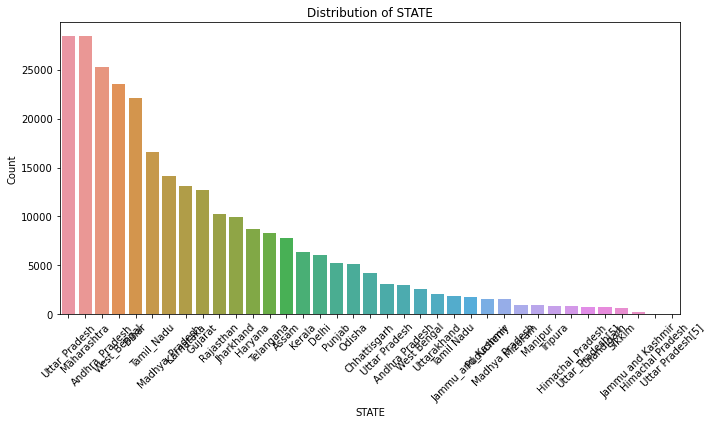

In [7]:
# Loop over each categorical variable to perform EDA
for col in lst_categorical_vars:
    print(f"Exploratory Data Analysis for '{col}':")
    print("-" * 50)
    
    # Number of unique categories
    unique_count = df_complete[col].nunique()
    print(f"Unique Categories: {unique_count}")
    
    # Missing values summary
    missing_count = df_complete[col].isna().sum()
    missing_pct = df_complete[col].isna().mean() * 100
    print(f"Missing Values: {missing_count} ({missing_pct:.2f}%)")
    
    # Value counts for each category
    print("Value Counts:")
    print(df_complete[col].value_counts())
    print("\n")
    
    # Plot a count plot (bar chart) for the variable
    plt.figure(figsize=(10, 6))
    order = df_complete[col].value_counts().index
    sns.countplot(data=df_complete, x=col, order=order)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
# Dropping state and city for having too many categories. With more time and resources, we group this categories in less groups
df_complete = df_complete.drop(['STATE', 'CITY', 'Profession'], axis = 1)

# Updating list of categorical columns (object or category types)
lst_categorical_vars = list(df_complete.select_dtypes(include=['object', 'category']).columns)

### Analysis of the numerical variables

Descriptive Statistics for Numerical Variables:


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,risk_flag
count,2.800000e+05,280000.000000,280000.000000,280000.000000,280000.000000,280000.000000
mean,5.000361e+06,49.964132,10.088032,6.334418,11.997193,0.123532
std,2.876988e+06,17.070465,6.005066,3.646864,1.398907,0.329048
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.506726e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.003310e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


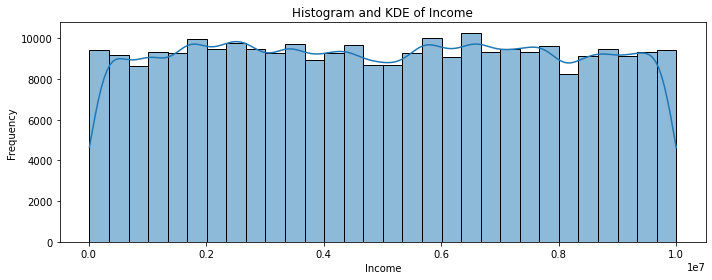

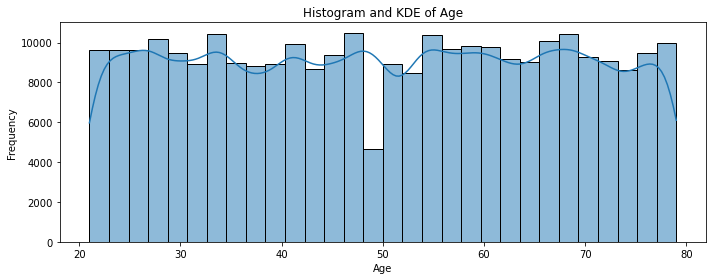

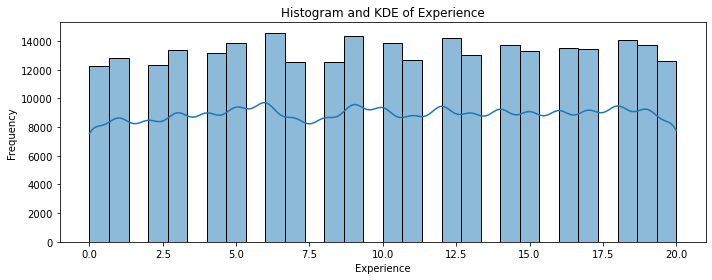

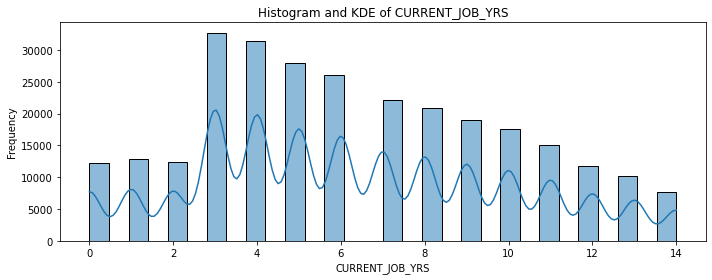

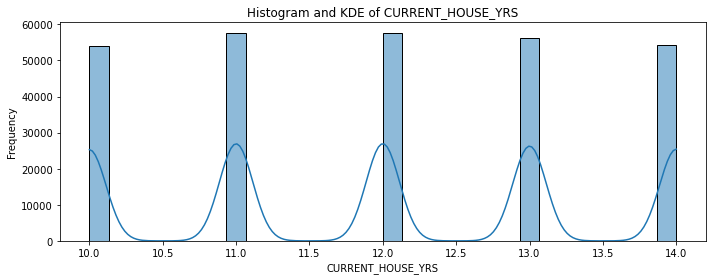

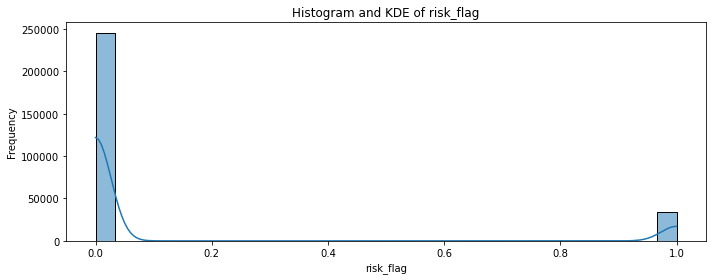

In [9]:
# 1. Descriptive Statistics
print("Descriptive Statistics for Numerical Variables:")
display(df_complete[lst_numerical_vars].describe())

# 2. Histograms with KDE for each numerical variable
for col in lst_numerical_vars:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_complete[col].dropna(), kde=True, bins=30)
    plt.title(f'Histogram and KDE of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### Correlation and trends

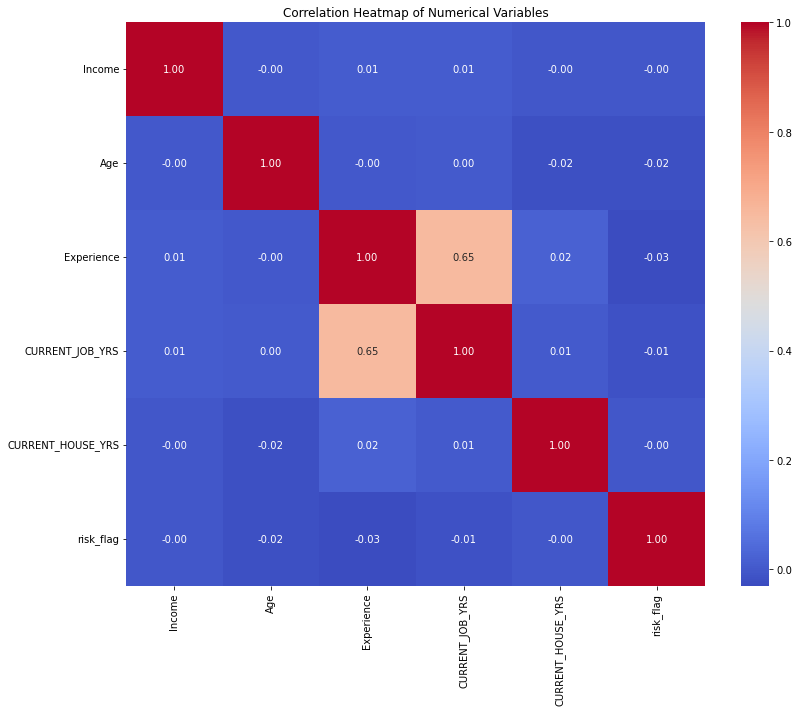

In [10]:
# 3. Correlation Heatmap among numerical variables
plt.figure(figsize=(12, 10))
corr = df_complete[lst_numerical_vars].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

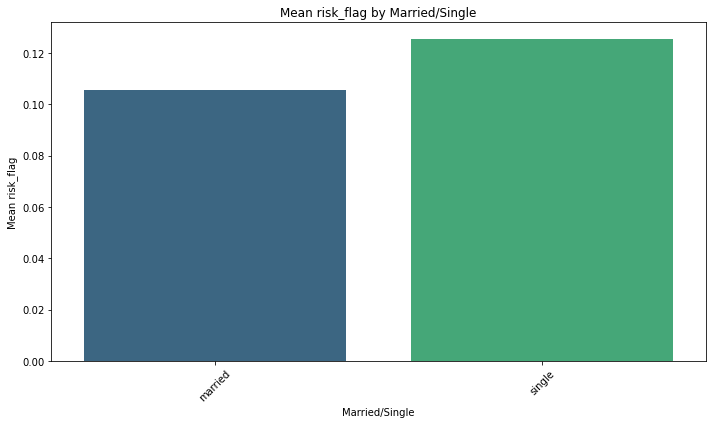

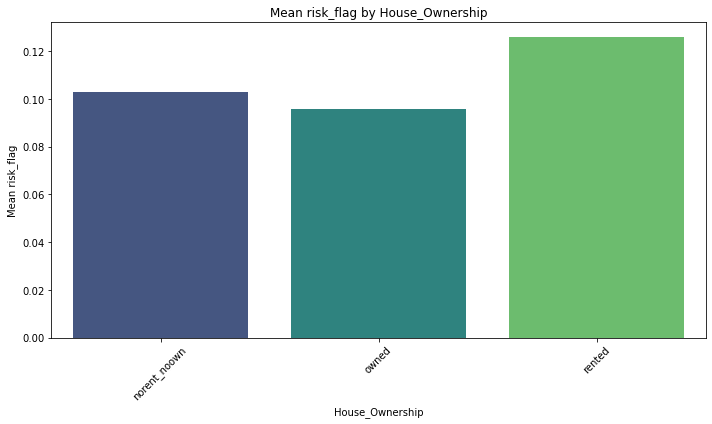

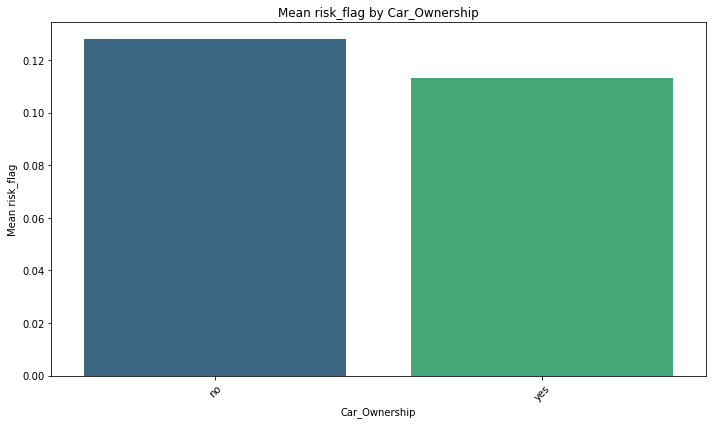

In [11]:
# Loop over each categorical variable and create a grouped mean bar plot
for col in lst_categorical_vars:

    # Skip the target variable if it appears in the categorical list
    if col == 'risk_flag':
        continue

    # Calculate the number of unique values in the column
    unique_count = df_complete[col].nunique()

    # Group by the categorical variable and compute the mean risk_flag (assumed binary)
    grouped = df_complete.groupby(col)['risk_flag'].mean().reset_index()

    # Do not show if there are too many categories
    if unique_count > 10:
        print("#############################################")
        print(f"You should consider drop the variable: {col}")
        print("#############################################")
    else:
        # Vertical bar chart: Use x-axis for categories and y-axis for risk_flag mean
        plt.figure(figsize=(10, 6))
        sns.barplot(x=col, y='risk_flag', data=grouped, palette='viridis')
        plt.title(f'Mean risk_flag by {col}')
        plt.xlabel(col)
        plt.ylabel('Mean risk_flag')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

## Data pre-processing

This section prepares the data for the model. Numerical variables are scaled. Categorical variables are transformed with one hot encoding.

### Categorical: One Hot Encoding

In [12]:
# One hot encoding the categorical variables to use them in the model
dummies = pd.get_dummies(df_complete[lst_categorical_vars], drop_first=True)
display(dummies)
dummies.shape

,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes
0,1,0,1,0
1,1,0,1,0
2,1,0,1,0
3,0,0,1,1
4,1,0,1,1
...,...,...,...,...
251995,1,0,1,0
251996,1,0,1,0
251997,1,0,1,0
251998,1,0,1,0


(280000, 4)

### Feature Scaling

In [14]:
# Leaving apart dummies and target variable
lst_categorical_and_target_variable = lst_categorical_vars + ['risk_flag']
df_target = df_complete['risk_flag']

df_complete = df_complete.drop(lst_categorical_and_target_variable, axis=1)
df_complete.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,7393090,59,19,4,13
1,1215004,25,5,5,10
2,8901342,50,12,9,14
3,1944421,49,9,3,12
4,13429,25,18,13,11


In [15]:
# Scaling variables

scale = MinMaxScaler()
scalled = scale.fit_transform(df_complete)

df_complete_scalled = df_complete.copy()
i = 0
for col in df_complete_scalled.columns:
    df_complete_scalled[col] = scalled[:,i]
    i += 1
df_complete_scalled.head()

# Display results before and after scaling
display(df_complete.describe())
display(df_complete_scalled.describe())

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
count,2.800000e+05,280000.000000,280000.000000,280000.000000,280000.000000
mean,5.000361e+06,49.964132,10.088032,6.334418,11.997193
std,2.876988e+06,17.070465,6.005066,3.646864,1.398907
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000
25%,2.506726e+06,35.000000,5.000000,3.000000,11.000000
50%,5.003310e+06,50.000000,10.000000,6.000000,12.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
count,280000.000000,280000.000000,280000.000000,280000.000000,280000.000000
mean,0.499523,0.499382,0.504402,0.452458,0.499298
std,0.287997,0.294318,0.300253,0.260490,0.349727
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249901,0.241379,0.250000,0.214286,0.250000
50%,0.499818,0.500000,0.500000,0.428571,0.500000
75%,0.747495,0.758621,0.750000,0.642857,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Get back dummies and target variable

df_ready = pd.concat([df_complete_scalled, dummies, df_target], axis=1)
print(df_ready.shape)
df_ready.head()

(280000, 10)


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes,risk_flag
0,0.739045,0.655172,0.95,0.285714,0.75,1,0,1,0,0
1,0.120594,0.068966,0.25,0.357143,0.00,1,0,1,0,0
2,0.890026,0.500000,0.60,0.642857,1.00,1,0,1,0,1
3,0.193612,0.482759,0.45,0.214286,0.50,0,0,1,1,0
4,0.000312,0.068966,0.90,0.928571,0.25,1,0,1,1,0


# Creating Training and Test Datasets

### Balancing Dataset

In [17]:
print(f"Number of observations for each class in the target variable:\n{df_ready['risk_flag'].value_counts(normalize=False)}")
print("")
print(f"We can also see it in percentage terms:\n{df_ready['risk_flag'].value_counts(normalize=True)*100}")

Number of observations for each class in the target variable:
0    245411
1     34589
Name: risk_flag, dtype: int64

We can also see it in percentage terms:
0    87.646786
1    12.353214
Name: risk_flag, dtype: float64


Since the target variable is very imbalanced, we are going to use under sampling before splitting the data.

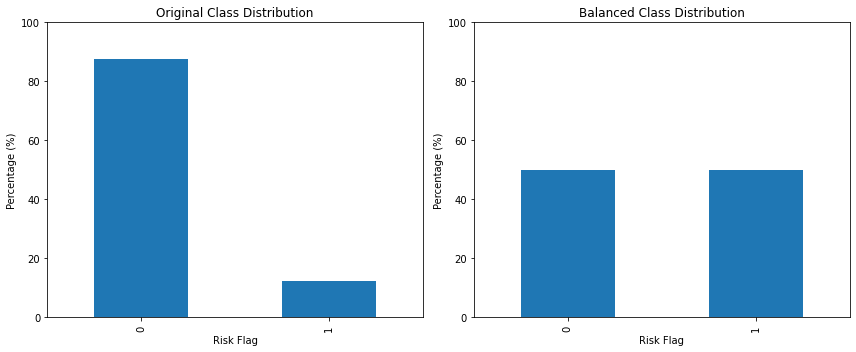

Shape of balanced dataset: (69178, 10)


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes,risk_flag
126354,0.061281,0.741379,0.50,0.714286,0.00,1,0,1,0,0
153122,0.240347,0.724138,0.15,0.214286,0.00,1,0,1,0,0
120745,0.588405,0.982759,0.30,0.214286,0.00,1,0,1,0,0
10995,0.065568,0.827586,0.55,0.785714,0.25,1,0,1,0,0
62993,0.940174,0.879310,0.45,0.357143,0.00,1,0,1,0,0


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes,risk_flag
251973,0.123559,0.241379,0.75,0.214286,0.25,1,0,1,0,1
251977,0.132167,0.724138,0.95,0.928571,0.50,1,0,1,0,1
251981,0.178826,0.448276,0.10,0.142857,0.50,1,0,1,0,1
251982,0.317527,0.534483,0.10,0.142857,0.00,1,0,1,0,1
251993,0.813916,0.672414,0.50,0.642857,0.75,1,0,1,0,1


In [18]:
# Identify minority and majority classes
class_counts = df_ready['risk_flag'].value_counts()
minority_class = class_counts.idxmin()  # class with fewer observations
majority_class = class_counts.idxmax()  # class with more observations
minority_count = class_counts.min()

# Separate the classes
df_minority = df_ready[df_ready['risk_flag'] == minority_class].copy()
df_majority = df_ready[df_ready['risk_flag'] == majority_class].copy()

# Under-sample the majority class for balancing
df_majority_sampled = df_majority.sample(n=minority_count, random_state=42)

# Create the balanced dataset
df_balanced = pd.concat([df_majority_sampled, df_minority], axis=0)

# Plot bar charts for class distribution before and after balancing
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Original dataset distribution
class_dist_original = df_ready['risk_flag'].value_counts(normalize=True) * 100
class_dist_original.sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title("Original Class Distribution")
axes[0].set_xlabel("Risk Flag")
axes[0].set_ylabel("Percentage (%)")
axes[0].set_ylim(0, 100)

# Balanced dataset distribution
class_dist_balanced = df_balanced['risk_flag'].value_counts(normalize=True) * 100
class_dist_balanced.sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title("Balanced Class Distribution")
axes[1].set_xlabel("Risk Flag")
axes[1].set_ylabel("Percentage (%)")
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Optional: Display dataset shapes and samples for further inspection
print(f"Shape of balanced dataset: {df_balanced.shape}")
display(df_balanced.head())
display(df_balanced.tail())

### Spitting Train and Test data¶

In [19]:
# Separating features and target variable
x, y = df_balanced.drop('risk_flag',axis=1), df_balanced['risk_flag']
print("BEFORE SPLITTING INTO TRAIN AND TEST:")
print(f"Shape of features: {x.shape}")
print(f"Shape of target variable: {y.shape}")

# We split the dataset setting a seed for reproducibility and stratifying by target variable
X_train, X_test, Y_train, Y_test = train_test_split(x, 
                                                    y, 
                                                    random_state=42, 
                                                    train_size=0.8, 
                                                    stratify=y)
# Print the result
print()
print("AFTER SPLITTING INTO TRAIN AND TEST:")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

BEFORE SPLITTING INTO TRAIN AND TEST:
Shape of features: (69178, 9)
Shape of target variable: (69178,)

AFTER SPLITTING INTO TRAIN AND TEST:
Shape of X_train: (55342, 9)
Shape of Y_train: (55342,)
Shape of X_test: (13836, 9)
Shape of Y_test: (13836,)


## Predictive Analytics

### Training and Testing models


Training Logistic Regression ...
Accuracy for Logistic Regression: 0.5279
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      6918
           1       0.53      0.56      0.54      6918

    accuracy                           0.53     13836
   macro avg       0.53      0.53      0.53     13836
weighted avg       0.53      0.53      0.53     13836



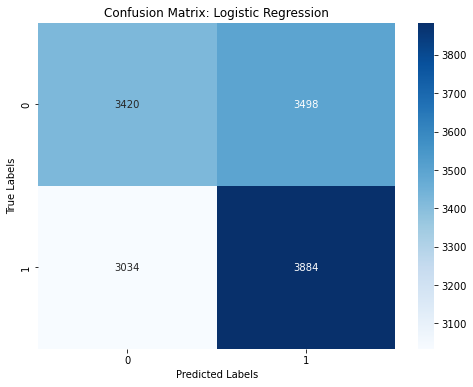


Training Random Forest Classifier ...
Accuracy for Random Forest Classifier: 0.8170
Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6918
           1       0.84      0.79      0.81      6918

    accuracy                           0.82     13836
   macro avg       0.82      0.82      0.82     13836
weighted avg       0.82      0.82      0.82     13836



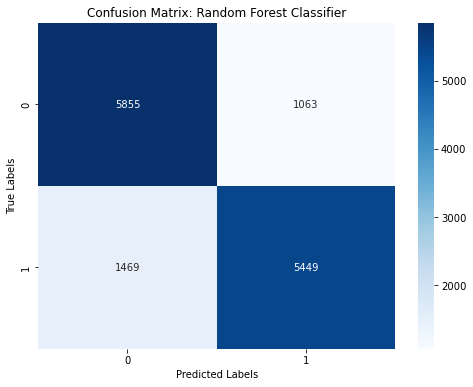

In [21]:
# Define the models with a fixed random state for reproducibility
models = [
    LogisticRegression(random_state=42, max_iter=1000),
    RandomForestClassifier(random_state=42)
]
model_names = ["Logistic Regression", "Random Forest Classifier"]
# Train, evaluate, and plot confusion matrix for each model
for model, name in zip(models, model_names):
    print(f"\nTraining {name} ...")
    model.fit(X_train, Y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test, y_pred)
    report = classification_report(Y_test, y_pred)
    
    # Display evaluation metrics
    print(f"Accuracy for {name}: {accuracy:.4f}")
    print(f"Classification Report for {name}:\n{report}")
    
    # Create and plot the confusion matrix
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

The Logistic Regression model struggles with this dataset, achieving only about 53% accuracy with similar precision and recall for both classes. This suggests it's barely performing above random chance on a balanced dataset. 

In contrast, the Random Forest model significantly outperforms Logistic Regression with an accuracy of around 82% and balanced precision, recall, and f1-scores across both classes. This indicates that the Random Forest is capturing the underlying patterns in the data more effectively, making it the preferred choice for this classification task.

### Feature importance


Plotting feature importance for Logistic Regression...


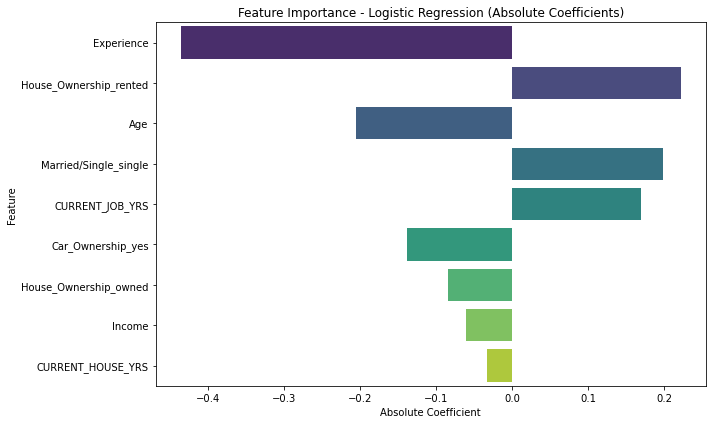


Plotting feature importance for Random Forest...


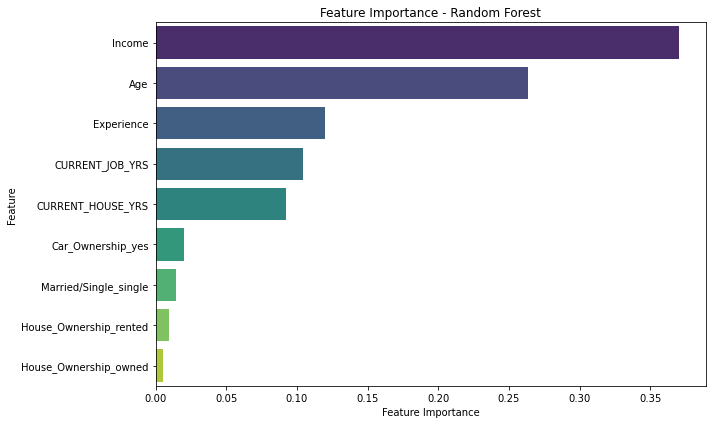

{'Logistic Regression':                   Feature  Coefficient  Abs_Coefficient
 2              Experience    -0.435530         0.435530
 7  House_Ownership_rented     0.221203         0.221203
 1                     Age    -0.205098         0.205098
 5   Married/Single_single     0.198537         0.198537
 3         CURRENT_JOB_YRS     0.169319         0.169319
 8       Car_Ownership_yes    -0.137775         0.137775
 6   House_Ownership_owned    -0.084753         0.084753
 0                  Income    -0.061366         0.061366
 4       CURRENT_HOUSE_YRS    -0.033058         0.033058,
 'Random Forest':                   Feature  Importance
 0                  Income    0.370669
 1                     Age    0.263167
 2              Experience    0.120146
 3         CURRENT_JOB_YRS    0.104569
 4       CURRENT_HOUSE_YRS    0.092505
 8       Car_Ownership_yes    0.020231
 5   Married/Single_single    0.014421
 7  House_Ownership_rented    0.009262
 6   House_Ownership_owned    0.005031

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train is a DataFrame containing your feature names
features = X_train.columns
feature_importance_results = {}  # Dictionary to store feature importance data

# Loop over the trained models to display feature importance
for model, name in zip(models, model_names):
    print(f"\nPlotting feature importance for {name}...")
    
    if hasattr(model, "coef_"):
        # For Logistic Regression: use absolute coefficient values
        importance_df = pd.DataFrame({
            "Feature": features,
            "Coefficient": model.coef_[0],
            "Abs_Coefficient": abs(model.coef_[0])
        }).sort_values("Abs_Coefficient", ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Coefficient", y="Feature", data=importance_df, palette="viridis")
        plt.title(f"Feature Importance - {name} (Absolute Coefficients)")
        plt.xlabel("Absolute Coefficient")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
        feature_importance_results[name] = importance_df
    elif hasattr(model, "feature_importances_"):
        # For Random Forest: use feature_importances_
        importance_df = pd.DataFrame({
            "Feature": features,
            "Importance": model.feature_importances_
        }).sort_values("Importance", ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
        plt.title(f"Feature Importance - {name}")
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
        feature_importance_results[name] = importance_df

# Return the feature importance results for further review
feature_importance_results

In Logistic Regression, higher Experience (–0.4355) and Age (–0.2051) reduce default risk, while renting a house (+0.2212) and being single (+0.1985) increase it. In contrast, Random Forest ranks Income (0.3707) as most important, followed by Age (0.2632) and Experience (0.1201). This suggests that while both models agree on the importance of Age and Experience, Random Forest captures additional non-linear effects with Income emerging as a key factor in predicting defaults.

# Acknowledgements

This notebook uses the dataset that can be found at: [Kaggle](https://www.kaggle.com/code/nandalald/loan-prediction-based-on-customer-behavior/notebook#Feature-Scaling)